Let's use the code to create X and Y as we did in last lecture

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# lets generate a dataset of 100 points
np.random.seed(2)
X = np.random.rand(1000,1)
y = 0.7*(X**5) - \
    2.1*(X**4) + \
    2.3*(X**3) + \
    0.2*(X**2) + \
    0.3* X + \
    0.4*np.random.rand(1000,1)


Now we divide our data into train and test

In [5]:
#0.8, 0.2 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [6]:
X_train.shape, X_test.shape

((800, 1), (200, 1))

If you remember, we had already seen how to find the optimal value of degree for polynomial regression in the last lecture

Let's use L2/Ridge regression model to tune our hyperparameters-degree and regularization rate

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

In [8]:
# Defining our performance metric
def adj_r2(X, y, r2_score):
  return 1 - ((1-r2_score)*(len(y)-1))/(len(y)-X.shape[1]-1)

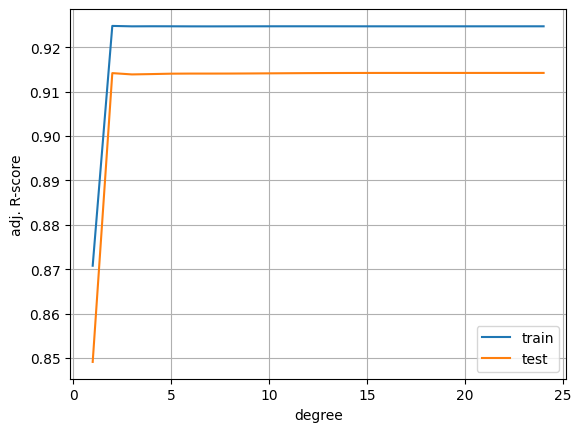

In [9]:
# Same as last lecture
max_degree = 25 # max polynomial degree
train_scores = []
test_scores = []
scaler = StandardScaler()
for degree in range(1, max_degree):
  polyreg_scaled = make_pipeline(PolynomialFeatures(degree), scaler, Ridge())
  polyreg_scaled.fit(X_train, y_train)
  train_score = adj_r2(X_train, y_train, polyreg_scaled.score(X_train, y_train))
  test_score= adj_r2(X_test, y_test, polyreg_scaled.score(X_test, y_test))
  train_scores.append(train_score)
  test_scores.append(test_score)

plt.figure()
plt.plot(list(range(1, 25)), train_scores, label="train")
plt.plot(list(range(1, 25)), test_scores, label="test")
plt.legend(loc='lower right')
plt.xlabel("degree")
plt.ylabel("adj. R-score")
plt.grid()
plt.show()


Based on this, the optimal degree would be somewhere around 3.

Now let's see how to optimize our regularization rate.

In [13]:
train_scores = []
test_scores = []
rate_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.01, 0.1, 1,5, 10]
scaler = StandardScaler()
for rate in rate_list:
  polyreg_scaled = make_pipeline(PolynomialFeatures(3), scaler, Ridge(alpha=rate))
  polyreg_scaled.fit(X_train, y_train)
  train_score = adj_r2(X_train, y_train, polyreg_scaled.score(X_train, y_train))
  test_score= adj_r2(X_test, y_test, polyreg_scaled.score(X_test, y_test))
  train_scores.append(train_score)
  test_scores.append(test_score)

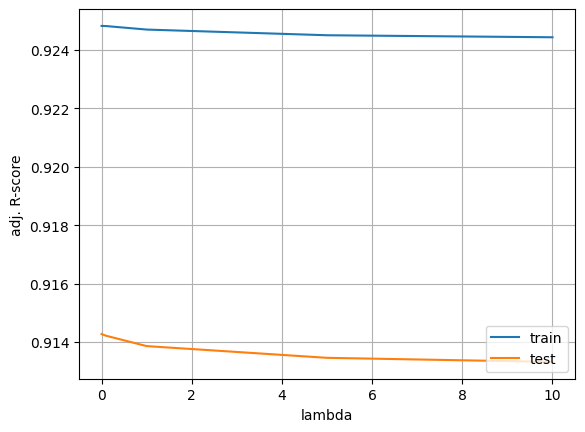

In [14]:
plt.figure()
plt.plot(rate_list, train_scores, label="train")
plt.plot(rate_list, test_scores, label="test")
plt.legend(loc='lower right')
plt.xlabel("lambda")
plt.ylabel("adj. R-score")
plt.grid()
plt.show()

In [15]:
test_scores

[0.9142745905126604,
 0.9142745899943189,
 0.9142745848109033,
 0.9142745329767664,
 0.91427401463801,
 0.9142688321768443,
 0.9142688321768443,
 0.9142176328264028,
 0.9138636295262608,
 0.9134626780435391,
 0.9133227560134852]

## Cross-Validation

Do you notice any problem with the above approach?

- We are **training our model on train data, but selecting based on test data**
- The test data doesn't remain unseen anymore, since the adj. R2 score is calculated based on it.

<img src ="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/471/original/image_2023-06-09_143437994.png?1686301518" height=600 width=600>


How do we solve this issue?

**By choosing a validation data**

We will divide our data into three parts
- $D_{train}$ = 60% of data (for training the model)
- $D_{CV}$ or $D_{val}$ = 20% of data (for hyperparameter tuning)
- $D_{test}$ = 20% of data
  - test data which will be unseen by the model
  - will only be used at the end to report the results of training



#### So how do we perform cross validation?

In [16]:
# lets generate a dataset of 100 points
np.random.seed(2)
X = np.random.rand(1000,1)
y = 0.7*(X**5) - \
    2.1*(X**4) + \
    2.3*(X**3) + \
    0.2*(X**2) + \
    0.3* X + \
    0.4*np.random.rand(1000,1)


Now we divide our data into train, test and validation

In [17]:
#0.6, 0.2, 0.2 split
from sklearn.model_selection import train_test_split
X_tr_cv, X_test, y_tr_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_tr_cv, y_tr_cv, test_size=0.25,random_state=1)

In [18]:
X_train.shape, X_val.shape, X_test.shape

((600, 1), (200, 1), (200, 1))

Let's visualize our data

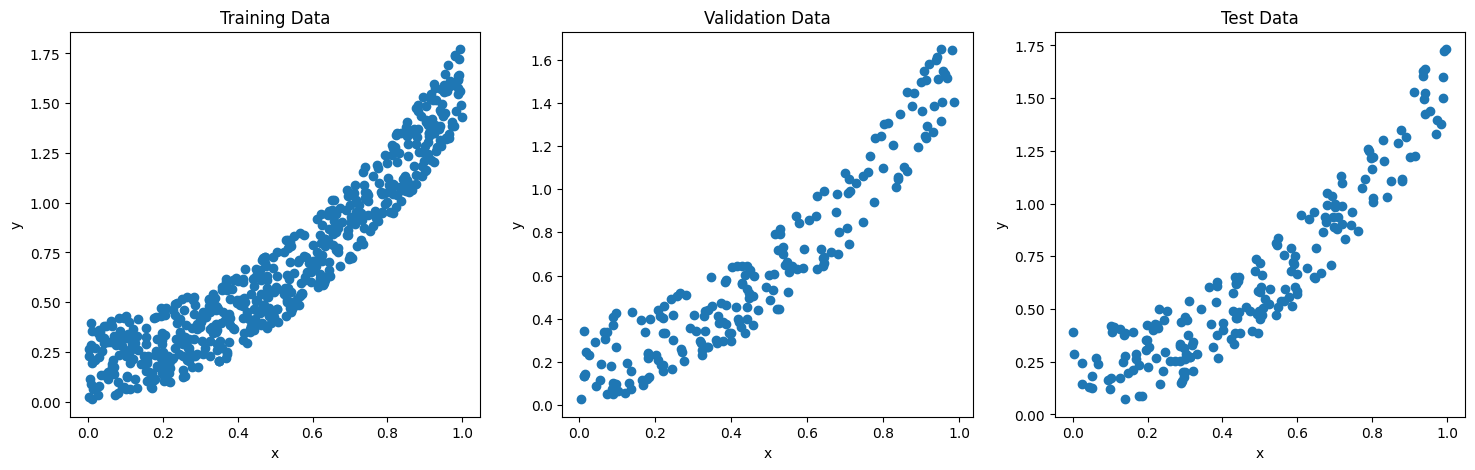

In [19]:
plt.figure(figsize=(18,5))
data_labels = ["Training Data", "Validation Data", "Test Data" ]
x_labels = [X_train, X_val, X_test]
y_labels = [y_train, y_val, y_test]
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.scatter(x_labels[i], y_labels[i])
  plt.xlabel("x")
  plt.ylabel("y")
  plt.title(data_labels[i])

The statistics of our type of data is similar, so we are good to go.

#### Steps to do cross-validation on our data



Now if you remember, in the last lecture we saw how the performance was increasing with increase in degree of the polynomial model

But how do we find the optimal degree in this case?

Let's

Let's try to find the optimal value of `degree` for our polynomial regression model

1. First we take degrees from 1 to 25, and train the model on data for each of these degrees to find the best degree

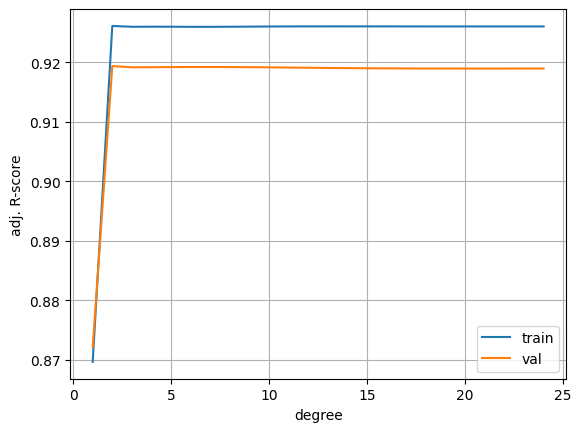

In [20]:
# Same as we did earlier and in the last lecture
max_degree = 25 # max polynomial degree
train_scores = []
val_scores = []
scaler = StandardScaler()
for degree in range(1, max_degree):
  polyreg_scaled = make_pipeline(PolynomialFeatures(degree), scaler, Ridge())
  polyreg_scaled.fit(X_train, y_train)
  train_score = adj_r2(X_train, y_train, polyreg_scaled.score(X_train, y_train))
  val_score= adj_r2(X_val, y_val, polyreg_scaled.score(X_val, y_val))
  train_scores.append(train_score)
  val_scores.append(val_score)
plt.figure()
plt.plot(list(range(1, 25)), train_scores, label="train")
plt.plot(list(range(1, 25)), val_scores, label="val")
plt.legend(loc='lower right')
plt.xlabel("degree")
plt.ylabel("adj. R-score")
plt.grid()
plt.show()

Taking degree=3, we now find the best regularization rate by the same process

In [21]:
train_scores = []
val_scores = []
rate_list = [0.01, 0.1, 1,5, 10]
for rate in rate_list:
  polyreg_scaled = make_pipeline(PolynomialFeatures(3), scaler, Ridge(alpha=rate))
  polyreg_scaled.fit(X_train, y_train)
  train_score = adj_r2(X_train, y_train, polyreg_scaled.score(X_train, y_train))
  val_score= adj_r2(X_val, y_val, polyreg_scaled.score(X_val, y_val))
  train_scores.append(train_score)
  val_scores.append(val_score)

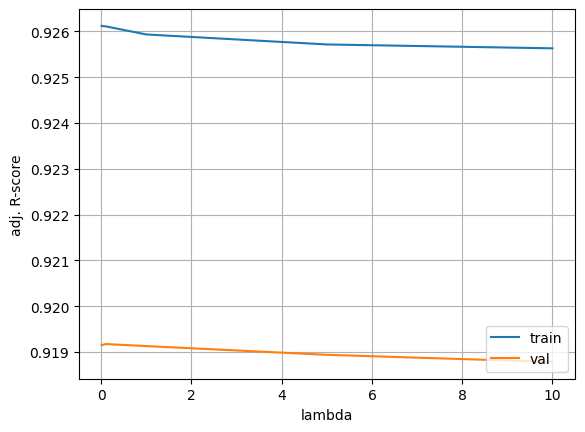

In [22]:
plt.figure()
plt.plot(rate_list, train_scores, label="train")
plt.plot(rate_list, val_scores, label="val")
plt.legend(loc='lower right')
plt.xlabel("lambda")
plt.ylabel("adj. R-score")
plt.grid()
plt.show()

We take the optimal value of lambda as 0.01

2. Now finally, we measure our model's performance on test data, which our model hasn't seen till now

In [23]:
polyreg_scaled = make_pipeline(PolynomialFeatures(3), scaler, Ridge(alpha=0.01))
polyreg_scaled.fit(X_train, y_train)
train_score = adj_r2(X_train, y_train, polyreg_scaled.score(X_train, y_train))
print(f'Training Score = {train_score}')
val_score = adj_r2(X_val, y_val, polyreg_scaled.score(X_val, y_val))
print(f'Validation Score = {val_score}')

Training Score = 0.9261212571628987
Validation Score = 0.9191482611247953


In [24]:
# Reporting this as the final score
test_score = adj_r2(X_test, y_test, polyreg_scaled.score(X_test, y_test))
print(f'Testing Score = {test_score}')

Testing Score = 0.9143625261065258


Observe, the test results are lower than training and validation.

This is because, our model hasn't seen the test data at all, and this can be said as the true result of our model.

#### Try for yourself

- Try to use Linear Regression, Lasso and ElasticNet and see how do the results vary?

But there is one issue with cross validation when there are less number of data points

## K-Fold Cross Validation

#### What would be the problem with Cross Validation in case there are less number of data points?

Suppose we are using a dataset with 100 data points

- On dividing the data between train, test and validation, only 60 datapoint are there for training
- Basically we are wasting 20 points in validation, which can also be used for training the data
- But we can't simply use 80% of our data for training, since this will again create the issue of no data for validation

#### How do we validate our data in case of lesser number of data points?

We use **K-Fold Cross Validation**

This is useful only for small datasets

#### What is k-fold cross validation?


Here, "k" denotes an integer, basically number of folds. This value can vary.

Let's take k=4

We divide our data into 4 parts, 3 for training and 1 for validation, and train our model k times, every time taking a different portion for validation

#### How to implement K-Fold Cross validation?

<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/198/original/image_2023-06-07_011139881.png?1686080500" height=600 width=600>

Steps:
- We train our model 4 times, and each time, one portion of the data is kept for validation, while other three portions are used for testing.
- After every training, we find the validation score as cv1, cv2, etc.
- Finally, the performance of the model is said to be the average of all these scores

Notice,
- We aren't wasting any data, since our model is training on all the sets, while also evaluating unseen data in each fold
- The average as metric will give us a higher confidence metric, compared to a single cv score

Usually, we take k=10

Let's look at the implementation.

In [25]:
# Creating a small dataset of 100 data points
np.random.seed(2)
X = np.random.rand(100,1)
y = 0.7*(X**5) - \
    2.1*(X**4) + \
    2.3*(X**3) + \
    0.2*(X**2) + \
    0.3* X + \
    0.4*np.random.rand(100,1)

In [33]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

In [34]:
from sklearn.linear_model import LinearRegression

# Performing k-fold cross validation
degrees = 15 # number of degrees
train_scores = []
val_scores = []

for degree in range(1, degrees):
    fold_train_scores = []
    fold_val_scores = []

    for train_index, val_index in kf.split(X): #iterating through the K-folds

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        polyreg_scaled = make_pipeline(PolynomialFeatures(degree), scaler, LinearRegression())
        polyreg_scaled.fit(X_train, y_train) #training model

        train_score = adj_r2(X_train, y_train, polyreg_scaled.score(X_train, y_train))
        val_score= adj_r2(X_val, y_val, polyreg_scaled.score(X_val, y_val))

        fold_train_scores.append(train_score)
        fold_val_scores.append(val_score)

    train_score = np.mean(fold_train_scores)
    val_score = np.mean(fold_val_scores)

    train_scores.append(train_score)
    val_scores.append(val_score)

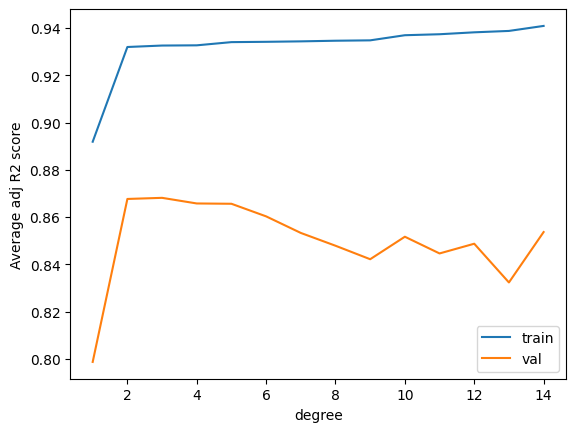

In [35]:
plt.figure()
plt.plot(list(range(1, 15)), train_scores, label="train")
plt.plot(list(range(1, 15)), val_scores, label="val")
plt.legend(loc='lower right')
plt.xlabel("degree")
plt.ylabel("Average adj R2 score")
plt.show()

In [36]:
from sklearn.linear_model import LinearRegression

# Performing k-fold cross validation
degrees = 15 # number of degrees
train_scores = []
val_scores = []

for degree in range(1, degrees):
    fold_train_scores = []
    fold_val_scores = []

    for train_index, val_index in kf.split(X): #iterating through the K-folds

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        polyreg_scaled = make_pipeline(PolynomialFeatures(degree), scaler, LinearRegression())
        polyreg_scaled.fit(X_train, y_train) #training model

        train_score = polyreg_scaled.score(X_train, y_train)
        val_score = polyreg_scaled.score(X_val, y_val)

        fold_train_scores.append(train_score)
        fold_val_scores.append(val_score)

    train_score = np.mean(fold_train_scores)
    val_score = np.mean(fold_val_scores)

    train_scores.append(train_score)
    val_scores.append(val_score)

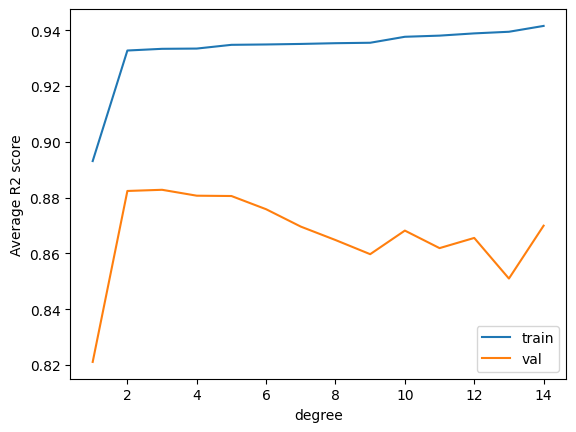

In [37]:
plt.figure()
plt.plot(list(range(1, 15)), train_scores, label="train")
plt.plot(list(range(1, 15)), val_scores, label="val")
plt.legend(loc='lower right')
plt.xlabel("degree")
plt.ylabel("Average R2 score")
plt.show()

Note:

- K-Fold Cross Validation can be computationally expensive
- Hence it's only used for Small datasets
- For large datasets, we have enough datapoints to train the model, hence only cross validation is sufficient

#### Let's start with our usecase for today!

## Introduction to AT&T Churn UseCase

AT & T, one of the leading telecommunications companies of USA, faces the challenge of customer churn, where customers switch to competitors due to issues such as bad network, poor customer service, and so on.

As a Data Scientist, you are tasked to develop a machine learning model to predict whether a customer will be churned or not, based on various parameters, such as state, number of evening calls, number of day calls, etc.

Let's look at the data

In [38]:
!gdown 1uUt7uL-VuF_5cpodYRiriEwhsldeEp3m

Downloading...
From: https://drive.google.com/uc?id=1uUt7uL-VuF_5cpodYRiriEwhsldeEp3m
To: /content/churn_logistic.csv
100% 494k/494k [00:00<00:00, 130MB/s]


In [39]:
import pandas as pd
churn = pd.read_csv("churn_logistic.csv")
churn.head()

,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Intl Plan,VMail Plan,Day Calls,...,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,State,Area Code,Phone,Churn
0,128,25,265.1,197.4,244.7,10.0,1,0,1,110,...,99,16.78,91,11.01,3,2.70,KS,415,382-4657,0
1,107,26,161.6,195.5,254.4,13.7,1,0,1,123,...,103,16.62,103,11.45,3,3.70,OH,415,371-7191,0
2,137,0,243.4,121.2,162.6,12.2,0,0,0,114,...,110,10.30,104,7.32,5,3.29,NJ,415,358-1921,0
3,84,0,299.4,61.9,196.9,6.6,2,1,0,71,...,88,5.26,89,8.86,7,1.78,OH,408,375-9999,0
4,75,0,166.7,148.3,186.9,10.1,3,1,0,113,...,122,12.61,121,8.41,3,2.73,OK,415,330-6626,0


**Data Description**
<center>

| Records | Features |
| :-- | :-- |
| 5700 | 21 |


| Id | Features | Description |
| :-- | :--| :--|
|01| **state** | 2-letter code of the US state of customer residence|
|02| **account_length** | Number of months the customer has been with the current telco provider |
|03|**area_code**|string="area_code_AAA" where AAA = 3 digit area code|
|04|**intl_plan**|The customer has international plan|
|05|**vmail_plan**| The customer has voice mail plan|
|06|**vmail_messages**|Number of voice-mail messages|
|07|**day_mins**|Total minutes of day calls|
|08|**day_calls**|Total no of day calls|
|09|**day_charge**|Total charge of day calls|
|10|**eve_mins**|Total minutes of evening calls|
|11|**eve_calls**|Total no of evening calls|
|12|**eve_charge**|Total charge of evening calls|
|13|**night_mins**|Total minutes of night calls|
|14|**night_calls**|Total no of night calls|
|15|**night_charge**|Total charge of night calls|
|16|**intl_mins**|Total minutes of international calls|
|17|**intl_calls**|Total no of international calls|
|18|**intl_charge**|Total charge of international calls|
|19|**customer_service_calls**|Number of calls to customer service|
|20|**phone**|10 digit number|
|21|**churn**|Customer churn - target variable|

In [40]:
churn['Churn'].value_counts()

0    2850
1    2850
Name: Churn, dtype: int64

Observe:
- The number of values are same for both "0" and "1"

## Intro to Logistic Regression

Before we dive into logistic regression, let's look at few notations we will be following.

<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/832/original/image_2023-06-14_170643599.png?1686742605" height=700 width=600>

**m**-> no. of samples

**d**-> no. of features

**n**-> no. of classes

**Data Notation**
- Data X: (m,d)
- $i^{th} \ sample: X^{(i)}$
- $j^{th} \ feature: X_j$
- Target: $(m,1)$ [Can convert to (m, n) for Softmax using preprocessing]
- True output: $y^{(i)}$
- Predicted output: $\hat{y}^{(i)}$

**Parameter Notation**
- $w=\begin{bmatrix}
	w_0 \\
	w_1 \\
	w_2 \\
  . \\
  . \\
  w_d
	\end{bmatrix}$

#### Recap

To solve this task, let's first recap what we have learnt in linear regression

<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/854/original/image_2023-06-14_184108752.png?1686748270" width=900 height=700>

Linear Regression was able to predict continuous values in the range of (-$∞$,$∞$)
- The linear model is a hyperplane with the eqn. $w^Tx^{(i)} + w_0$
- We can simply predict the value by inserting $x^{(i)}$ in the above equation
- The loss function was MSE = $\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}-\hat{y}^{(i)})^2$

But in our problem, we need to classify the values.

#### What kind of algorithm is logistic regression?

- It is a supervised algorithm
- Mainly used for classification tasks
- Can only solve binary classification problems

**Do you guys remember the fish sorting problem from "Maths for ML" module?**

It can be stated as,
$D = \{(x^{(i)}, y^{(i)})^m_{i=1}; x^{(i)} \in R^d; y^{(i)} \in \{0,1\}, y^{(i)} ∉ R\}$

For any given value of x, y belongs only to either 0 or 1, and it can't be a real number other than 0  and 1

Our customer churn problem is very similar to this

<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/618/original/image_2023-06-12_170400234.png?1686569642" width=700 height=600>

The task in classification is to be able to separate the two classes
- The hyperplane above is very similar to the one we studied in linear regression.
- The **main difference** is

  - In Lin. Reg., we were finding the line of best fit in d+1 dimensional space,i.e., d feature and y (target variable)
  - But in Logistic Regression, we are looking for a hyperplane in d-dimensional space.

We know a linaer regression model gives output as a continous value from $-∞$ to $∞$.

#### What should we modify in a linear model to be able to give values as either 0 or 1?

We will use something called as thresholding

## Thresholding and Step Function

We know $y^{(i)}=w^Tx^{(i)}+w_0 \in \{-∞,∞\}$

We now apply a function g() over this to threshold the values to {0,1}

So,

=> $z^i=w^Tx^{(i)}+w_0 \xrightarrow{\text{g()}}=\{0,1\}$

#### What function can we use to threshold the values?

We can select our own threshold value, and set the condition based on that.

The function would look like a step.

<!-- ![](https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/203/original/image_2023-06-07_040209045.png?1686090730) -->

<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/203/original/image_2023-06-07_040209045.png?1686090730" width="600" height="600">


Whenever $z^i$ >= threshold, its 1, else it's 0

#### Do you notice a problem with this step function?

It is non-differentiable, and hence, we cannot perform derivative operation.

#### What better function can we use other than step function to threshold our values?

## Sigmoid/Logistic Function

The term "logistic regression" comes from this function
- At the base, it's doing regression only
- On top of Regression, we are applying logistic function, hence logistic regression

#### What is the sigmoid function?

<!-- ![](https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/204/original/image_2023-06-07_050559293.png?1686094560) -->

<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/204/original/image_2023-06-07_050559293.png?1686094560" width="600" height="600">

The sigmoid function, denoted by sigma $σ$, is differentiable as can be seen.

- As $z^{(i)}$ tends to $\infty$, $σ(z^{(i)})$ tends to 1
- As $z^{(i)}$ tends to $-\infty$, $σ(z^{(i)})$ tends to 0
- For $z^{(i)}$ = 0, $σ(z^{(i)})$ = 0.5


#### How to we calculate $σ(z^i)$ mathematically?



$σ(z^i) = \frac{1}{1+e^{-z^i}} = \frac{1}{1+e^{-(w^Tx^i+w_0)}}$

## Implementation

#### Defining sigmoid function

In [41]:
def sigmoid(x):
    return 1/(1+np.e**-x)

In [42]:
sigmoid(1.99)

0.8797431375322491

In [43]:
sigmoid(0)

0.5

In [44]:
sigmoid(-0.9)

0.28905049737499605

#### Visualizing sigmoid

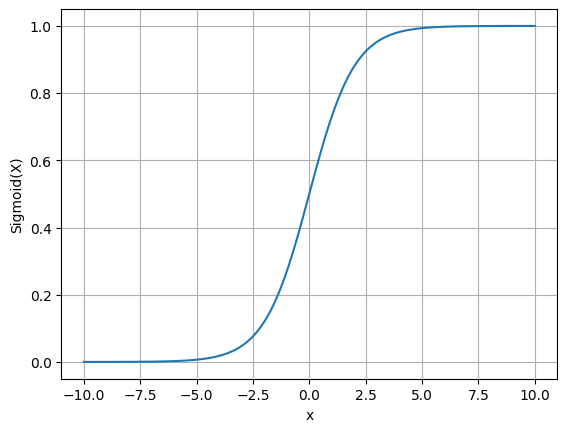

In [45]:
x = np.linspace(-10, 10, 100) # 100 equidistant points between -10 and 10
y = sigmoid(x)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")
plt.grid()
plt.show()

Observe,

- The curve of sigmoid looks exactly like an S shape curve with cutting the y axis for x=0, at y=0.5

Now that we have the sigmoid function, what loss function should we use?

#### What are the properties of sigmoid function?


- It is smooth and differentiable
- Also called squashing function, since it squashes the infinite values to (0,1)
- Can be used as probabilities of class 1
- It's monotonic in nature (non-decreasinng)
  - At any moment, if we take two points $x_1$ > $x_2$, $σ(x_1)$ will always be greater than $σ(x_2)$

The output of sigmoid function can be thought of as a probability of a point belonging to class 1

$\hat{y}^{(i)}=P(y^i=1|x^i)$

E.g.
=> If we get sigmoid value as 0.18, it means there's a 18% chance the point belongs to class 1

There is one issue though with sigmoid function.

#### What is a problem with sigmoid function being used for classification?

We are getting continuous values in the range of {0,1}

Can you suggest a way to convert this to categorical values?

#### **Thresholding**

We can take a threshold of 0.5

So values >= 0.5 will be 1, else 0

## Geometric Interpretation of Sigmoid

**Quiz **  (What do you think?)

![](https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/476/original/image_2023-06-09_144901538.png?1686302353)

```
Which point will have a higher probability of belonging to class 1?

A. x1
B. x2
C. Equal probability
D. Can't be said from this information

Ans: x1
```
Explanation:
x1 will have a larger distance from the plane, so the $\sigma$ value will be higher for x1

Let's draw a scatterplot for 2 features, with 2 classes as output

Here, $π$ is the model, also called the separating hyperplane

<!-- ![](https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/230/original/image_2023-06-07_124743184.png?1686122265) -->

<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/230/original/image_2023-06-07_124743184.png?1686122265" width="600" height="600">

Let's take a point $x^1$

- We know, $z^{(1)}$ = $W^Tx^{(1)}+w_0$, let's assume this value to be 1.99
- $\sigma(z^{(1)})=0.88$
- This implies, the point $x^{(1)}$ has a 88% probability of belonging to class 1(yellow points)

All the points above the line will have $z^{(i)} > 0$, hence $σ(z^i)>0.5$, so they will be assigned to class 1


Let's take the point $x^{(2)}$

- Let's assume this value to be -0.9. (will be negative since below the line)
- $\sigma(z^{(2)})=0.29$
- This implies, the point $x^{(2)}$ has a 29% probability of belonging to class 1, or 71% probability of belonging to class 0

All the points below the line will have $z^{(i)} < 0$, hence $σ(z^{(i)})<0.5$, so they will be assigned to class 0


Similarly, for point $x^{(3)}$, $z^{(3)}=0$, so $σ(z^{(i)})=0.5$, and since our threshold is 0.5, it will belong to class 1

**Conclusion:**

- Closer the point is to hyperplane,
    - more unsure we are with its probability of it belonging to a specific class

- Farther it is from hyperplane,
    - more confident we are of it belonging to specific class.

**Quiz ** (Check your understanding)

![](https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/478/original/image_2023-06-09_145616657.png?1686302778)
```
Which point will have a higher probability of belonging to class 1?

A. x1
B. x2

Ans: x1
```

Explanation:
- x1 is nearer to the line, while x2 is farther, on the negavtive side.
- Hence x2 will have a higher chance of belonging to class 0,
- which conversely means it will have a lower chance than x1 to belong to the class 1


# **Maximum Log-likelihood**

Recall, we learnt that sigmoid is just like a conditional probability

$P(y^{(i)}= 1|x^{(i)}) = σ(w^Tx^{(i)} + w_0)$ and

$P(y^{(i)} = 0|x^{(i)}) = 1 - P(y^{(i)} = 1|x^{(i)})$

<!-- ![](https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/367/original/image_2023-06-08_121629941.png?1686206792) -->


<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/802/original/image_2023-06-14_160836011.png?1686739118" width="700" height="600">

Lets call $ P(y^{(i)} = 1|x^{(i)}) = p$, then we can say:


$P(y^{(i)} = 1 |x^{(i)}) = $
\begin{cases}
 \text{$p \ \  \ \ \ \ \ \ $ if $y^{(i)} = 1$} \\
 \text{$1-p \ $ if $y^{(i)} = 0$}
\end{cases}



<br>

**Observe**

This is nothing but a Bernoulli Distribution

<br>










#### What will be the Probability Distribution Function (pdf) of a Bernoulli Distribution ?

Ans: $pdf = p^y (1-p)^{(1-y)}$

#### If there are n samples, what will be the Likelihood ?

Ans: Likelihood $= ∏_{i=1}^{n} pdf = ∏_{i=1}^{n} {p^{(i)}}^{y{(i)}} (1-p^{(i)}) ^{(1-y^{(i)})}$


#### <font color='green' >(Optional)</font> Difference between likelihood and probability ?

Let's try to understand the difference between likelihood and probability

Say, we plot the distribution of data of **students scores in module test**

- x axis is the marks and y axis the frequency (or density as in a kde plot)

Our task is to find the **probability** of a student's score lying in the range of 60 to 70


<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/991/original/image_2023-06-16_182444262.png?1686920086" height=600 width=600>

The probability can be said as
- the area under the distribution curve for the range of 60 and 70
- in this case it would be 0.29, or 29%

The notation would be
- $pr(data|distribution)$

#### What about likelihood?

Say we want to find the likelihood of a student getting 63 marks?

<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/992/original/image_2023-06-16_182956942.png?1686920398" height=600 width=600>

That would simply be the value on the y-axis for the distribution, in this cae, 0.12

The notation would be
- $L(dist.|data)$

So what's the major difference?

- In likelihood the data is fixed, we move the distribution to fit the data.
- In probability, we change the data as per our requirement.

On a simpler terms,
- Probability refers to the possibility of something happening
- While likelihood refers to determining the data distribution for a given data point


#### So how is this conneted to MLE in logistic regression?

- Likelihood function determines the distribution given some observed data
- In logistic regression, we are given the observed data for which we are trying to find the parameters to
- MLE maximizes the likelihood of the likelihood function to be able to estimate the parameters of the observed data

<!-- **Assume** we toss a fair coin.

**What'll be the probability of getting a heads?**
=> 1/2 or 0.5

**What'll be the probability of getting a tails?**
- Same. 0.5

Notice that
- when calculating probability or how likely a specific outcome will occur
- we started off with an assumed condition

The condition in this case was **fair coin** -->


<!--
Now take **another example**:

Say, we tossed a coin 10 times.
- Out of 10 we got 8 heads and 2 tails.

based on this, we want to know whether it is a fair coin or biased coin.

Notice that
- this time there is **no assumption** whether we have fair coin or baised coin
- and we are provided with observed data (coin tossed 10 times.)

Based on this, we get the **likelihood**
- i.e. get the plausibility of hypothesis based on observed data.

It is basically reverse engineering.
- Instead of giving us a assumption,
    - we are given a data and have been asked to whether the assumption will hold for this data.
    - This is where we calculate the likelihood of it.


 -->


<!--
**So, why likelihood when performing MLE?**

In logistic regression, We are trying to **find the parameters** of a model based on **observed data**


- and likelihood tells us plausibility of how well the chosen parameters explain the observed data. -->

### Maximizing Likelihood Estimation

<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/855/original/image_2023-06-14_184500587.png?16867485016" width="700" height="700">


Taking log:

$$log-Likelihood = log(∏_{i=1}^{m} {p^{(i)}}^{y^{(i)}} (1-p^{(i)}) ^{(1-y^{(i)})}) $$

Since we know $log(a^b) = blog(a)$ and $log(a \times b) = log(a) + log(b)$

$$log-Likelihood = ∑_{i=1}^{m} y^{(i)}log(p^{(i)}) + (1-y^{(i)})log(1-p^{(i)}) $$

<br>


#### As Gradient Descent works to minimize the function , how to convert log-likelihood  into a minimizing function ?

Ans: Negate the whole equation.


$$log-Likelihood = -( ∑_{i=1}^{m} y^{(i)}log(p^{(i)}) + (1-y^{(i)})log(1-p^{(i)}) )$$

**Note**
- This negative log-likelihood is called as **LogLoss**

Let's break it down into a more simpler form



We can write the above as:


![](https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/390/original/image_2023-06-08_151021163.png?1686217222)

We plot the error vs prediction plot for $y^{(i)}=0$ and $y^{(i)}=1$

![](https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/389/original/image_2023-06-08_150634589.png?1686217005)


We can further generlize it as:


<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/616/original/image_2023-06-12_165820582.png?1686569303" width=600>



Notice, this is the same as our negative log likelihood we dervied earlier


### Why can't we use MSE as loss for classification?

Before we dive into this, let's look at convex and non convex fuction

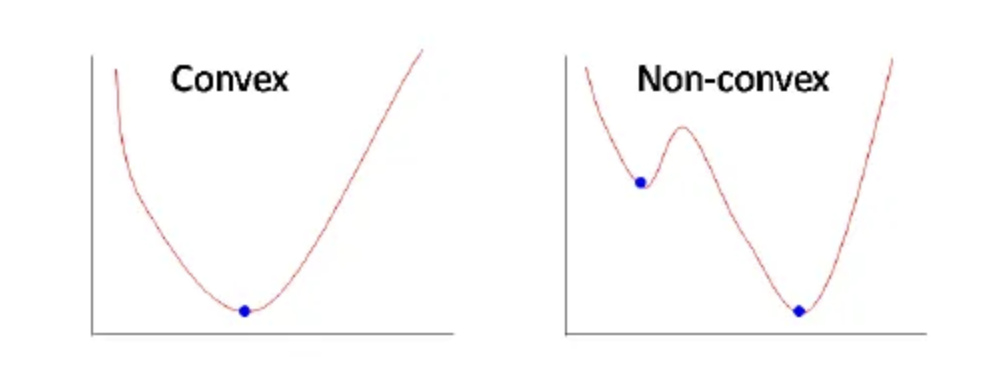

Notice that
- convex function has only single minima i.e. global minima
- while non convex has more than one minima i.e. local as well as global minima

#### What function would you prefer when solving for optimization problem of logisitic regression ?

Convex, right ?

If we choose non convex function
- then there is a change that we'll get stuck in local minima while solving using SGD
- and won't be able to reach optimal solution

So, we want convex function

**But, if we choose MSE with sigmoid, it'll be a non convex function.**
- and we may not reach optimal solution.



#### But, we use MSE for linear regression. It was giving optimal solution. Why didn't we face this issue over there?

Yes. Pay attention

- **MSE when used with sigmoid as predictor** turns out to be non convex.

We didn't use sigmoid as predictor in linear regression. Hence, it was convex over there

#### Why MSE used with sigmoid is non convex?

There's a mathematical proof behind it. If you are interested, you can read more here: https://towardsdatascience.com/why-not-mse-as-a-loss-function-for-logistic-regression-589816b5e03c

Hence, **we choose logloss with sigmoid**
- which is a convex function

and gurantees that we reach optimal solution.

### Let's implement log-loss now


In [46]:
# Loss for a single point
def log_loss(y, y_hat):
  loss = y*np.log(y_hat)+(1-y)*np.log(1-y_hat)
  return -loss

In [49]:
# Case 1, yi=1, high pi
log_loss(1, 0.99999)

1.0000050000287824e-05

Observe, how small log loss is

In [50]:
# Case 2, yi = 1, pi =0.5

log_loss(1, 0.5)

0.6931471805599453

In [53]:
# Case 3, yi = 1, low pi

log_loss(1, 0.001)

6.907755278982137

In [54]:
log_loss(0,0.01)

0.01005033585350145

Observe, how high the log loss is

**QUIZ ** (Check your knowledge)

```
Supposedly your y = 0 and ŷ = 0.01 , so what be the log-loss ?

A. log-loss will be a very high value

B. log-loss will be a very low value

C. log-loss will be 0
```
**Answer**

B. log-loss will be a very low value

Explanation: This is similar to log_loss(1,0.99)


## Optimization

Let's now start with optimization of the NLL, i.e., perform gradient descent

#### Do we need regularization?

Yes, we can add regularization to prevent overfitting of the model

<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/856/original/image_2023-06-14_184708703.png?1686748629" width=600 height=600>

We already know the derivative of the regularization term:
$2λw_j$

So we just need to now perform argmin on the Loss function equation

<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/857/original/image_2023-06-14_184826743.png?1686748708" width=700 height=700>

Now that we know sigmoid  is differentiable, lets find the gradient of the log-loss,

log-loss is defined as:
 $$Logloss (L) = min_{w_j}∑_{i=1}^m[-y^{(i)})
 log({\hat{y}}^{(i)}) - (1-y^{(i)}))log(1-{\hat{y}}^{(i)})]$$

What all we know

$$\frac{d log(x)}{dx} = \frac{1}{x}$$
$$ σ'(z) = σ(z)(1-σ(z)) $$
$$ \frac{\partial (w^Tx^{(i)})+w_0)}{\partial w_j} = x_{j}^{(i)} $$


Let's take the derivative for one point, then we can later generalize for m points

We know,
$\hat{y}=σ(z)=\sigma (w_1x_1+w_2x_2+...+w_jx_j+....)$

We will divide our equation into two parts, and apply the derivation on each of them

![image.png](https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/419/original/image_2023-06-08_181924139.png?1686228566)

Now Using the concept of chain rule for A:

$$\frac{\partial LA}{\partial w_j} = \frac{\partial A}{\partial \hat{y}} * \frac{\partial \hat{y}}{\partial z} * \frac{\partial z}{\partial w_j} $$

$$=> y(1-\hat{y}) * x_j$$





![](https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/420/original/image_2023-06-08_182013621.png?1686228615)

Similarly, for B,



$$\frac{\partial LB}{\partial w_j} = \frac{\partial B}{\partial (1- \hat{y})} *\frac{\partial (1-\hat{y})}{\partial \hat{y}} * \frac{\partial \hat{y}}{\partial z} * \frac{\partial z}{\partial w_j} $$

$$=>-(1-y)*\hat{y} * x_j$$





![](https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/421/original/image_2023-06-08_182058379.png?1686228660)

Summing these

$$\frac{\partial L}{\partial w_j} = \frac{\partial LA}{\partial w_j}+\frac{\partial LB}{\partial w_j} $$
$$=[y-\hat{y}]x_j$$


<img src="https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/858/original/image_2023-06-14_185306941.png?1686748988" width=700 height=700>

For all points from 1 to m,

$$\frac{\partial L}{\partial w_j} = \frac{1}{m}+\sum_{i=1}^{m} (\hat{y}^{(i)}-y^{(i)}*x^{(i)}_j $$

Notice,

this is same as linear regression.

The only difference is

- $\hat{y}=w^Tx+w_0$ for linear regression
- $\hat{y}=σ(w^Tx+w_0)$ for logistic regression

Finally, the gradient descent will be the same as earlier

![](https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/036/423/original/image_2023-06-08_182421119.png?1686228863)

<font color='red'> The scratch implementation of LogisticRegression is in the PostRead. </font>
- https://colab.research.google.com/drive/16OjEQ0RExT7AlgyasMlvyvdCt0TNB18m?usp=share_link